Experiment description
 - Continual Learning using MLP model
 - CL strategy: Finetuning
 - Dataset: MNIST
 - Task organization: Class-Incremental learning
 - Data preprocessing: As offered in Pytorch library

Experiment Result: CF was way too much, 0 accuracy for all former tasks
 - reasoning for the result: 
 No CF preventing measure, just class-incremental learning by tasks
 CNN's good ability to learn  weight and bias and being adjusted to the current training task

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import random
import os

from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset
from torch.utils.data.dataloader import default_collate
from torch.autograd import Variable
from torchvision import datasets
from tqdm import tqdm

import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/CL_experiments_MNIST')
import data
import utils

# from avalanche.benchmarks.classic import SplitMNIST

In [2]:
# Define relevant variables for the ML task
batch_size = 32
num_class = 10
num_epoch = 20

# Device will determine whether to run the training on GPU or CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# generate permutations for the tasks.
np.random.seed(0)
permutations = [
    np.random.permutation(data.DATASET_CONFIGS['mnist']['size']**2) for
    _ in range(5)
]

# prepare mnist datasets.
train_datasets = [
    data.get_permuted_dataset('mnist', permutation=p) for p in permutations
]
test_datasets = [
    data.get_permuted_dataset('mnist', train=False, permutation=p) for p in permutations
]

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./datasets/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./datasets/mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./datasets/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./datasets/mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./datasets/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./datasets/mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./datasets/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./datasets/mnist/MNIST/raw



In [4]:
# load task-specific training & test dataset - from training_datasets
t_train_loaders = []
t_test_loaders = []
for idx, train_dataset in enumerate(train_datasets, 1):
    print(idx)
    task, dummy = random_split(train_dataset, [12000, len(train_dataset) - 12000])
    t_train, t_test = random_split(task, [int(len(task) * 0.8), len(task) - int(len(task) * 0.8)])
    print('len(t_train): {}'.format(len(t_train)))
    print('len(t_test): {}'.format(len(t_test)))
    t_train_loaders.append(data.get_permuted_data_loader(t_train, batch_size=batch_size))
    t_test_loaders.append(data.get_permuted_data_loader(t_test, batch_size=batch_size))

# load general test dataset - from test_datasets
test_dataset = []
for dataset in test_datasets:
    test_dataset = ConcatDataset([test_dataset, dataset])
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

1
len(t_train): 9600
len(t_test): 2400
2
len(t_train): 9600
len(t_test): 2400
3
len(t_train): 9600
len(t_test): 2400
4
len(t_train): 9600
len(t_test): 2400
5
len(t_train): 9600
len(t_test): 2400


In [5]:
# Check Data Shape
# Check # of samples in each set
data.data_size_check(t_train_loaders, "task-specific train")
data.data_size_check(t_test_loaders, "task-specific test")
data.data_size_check([test_loader], "Overall test")

Data size check of task-specific train DataLoaders
Task_1:
t1_task-specific train:
# of samples: 9600
data size: torch.Size([32, 1, 784])
data[0] size: torch.Size([1, 784])
labels size: torch.Size([32])

Task_2:
t2_task-specific train:
# of samples: 9600
data size: torch.Size([32, 1, 784])
data[0] size: torch.Size([1, 784])
labels size: torch.Size([32])

Task_3:
t3_task-specific train:
# of samples: 9600
data size: torch.Size([32, 1, 784])
data[0] size: torch.Size([1, 784])
labels size: torch.Size([32])

Task_4:
t4_task-specific train:
# of samples: 9600
data size: torch.Size([32, 1, 784])
data[0] size: torch.Size([1, 784])
labels size: torch.Size([32])

Task_5:
t5_task-specific train:
# of samples: 9600
data size: torch.Size([32, 1, 784])
data[0] size: torch.Size([1, 784])
labels size: torch.Size([32])

------\--------
Data size check of task-specific test DataLoaders
Task_1:
t1_task-specific test:
# of samples: 2400
data size: torch.Size([32, 1, 784])
data[0] size: torch.Size([1, 784

Model

In [19]:
# model = utils.CNN(num_class).to(device)
model = utils.MLP(input_size=28*28, output_size=10, hidden_dropout=True, input_dropout=True).to(device)

#Use SGD, learning rate=0.001
lr1 = 0.001
optimizer = optim.SGD(model.parameters(), lr=lr1, weight_decay = 0.005, momentum = 0.9)

In [20]:
for name, param in model.named_parameters():
    print(name)

fc1.weight
fc1.bias
fc2.weight
fc2.bias
fc3.weight
fc3.bias
fc4.weight
fc4.bias


Training & Evaluation

In [21]:
train_ac_list = []

t1_test_ac_list = []
t2_test_ac_list = []
t3_test_ac_list = []
t4_test_ac_list = []
t5_test_ac_list = []
task_ac_list = np.zeros((5,6)).tolist()

test_ac_list = []

Period 1 - pretrained: [None] training [t1_train], testing [t1_test]

In [22]:
print("Period 1 training")
for epoch in range(num_epoch):
    train_ac_list = utils.training(model, optimizer, t_train_loaders[0], train_ac_list, epoch, task_idx=1)

    t1_test_ac_list = utils.testing(model, t_test_loaders[0], t1_test_ac_list, epoch, task_idx=1)
    
    if (epoch+1)%5 == 0:
        print('-------------------------------------------------------------------')

print()
test_ac_list = utils.testing(model, test_loader, test_ac_list, epoch=0, task_idx=0)

task_ac_list[0][0] = t1_test_ac_list[-1]  # task-specific test accuracy

Period 1 training
Epoch_5: task_1 Train_Acc: 0.8479
Epoch_5: task_1 Test_Acc: 0.8833
-------------------------------------------------------------------
Epoch_10: task_1 Train_Acc: 0.9102
Epoch_10: task_1 Test_Acc: 0.9113
-------------------------------------------------------------------
Epoch_15: task_1 Train_Acc: 0.9304
Epoch_15: task_1 Test_Acc: 0.9258
-------------------------------------------------------------------
Epoch_20: task_1 Train_Acc: 0.9491
Epoch_20: task_1 Test_Acc: 0.9367
-------------------------------------------------------------------

Epoch_1: Overall Test_Acc: 0.2767


Period 2 - pretrained: [t1_train] training [t2_train], testing [t1_test, t2_test]

In [23]:
# Fine-tuning
# print(model.state_dict)
for param in model.parameters():
    param.requires_grad = False

model.fc4.weight.requires_grad = True
model.fc4.bias.requires_grad = True

optimizer = optim.SGD(model.parameters(), lr=0.001, weight_decay = 0.005, momentum = 0.9)

In [24]:
print("Period 2 training")
for epoch in range(num_epoch):
    train_ac_list = utils.training(model, optimizer, t_train_loaders[1], train_ac_list, epoch, task_idx=2)

    t1_test_ac_list = utils.testing(model, t_test_loaders[0], t1_test_ac_list, epoch, task_idx=1)
    t2_test_ac_list = utils.testing(model, t_test_loaders[1], t2_test_ac_list, epoch, task_idx=2)
    
    if (epoch+1)%5 == 0:
        print('-------------------------------------------------------------------')

print()
test_ac_list = utils.testing(model, test_loader, test_ac_list, epoch=0, task_idx=0)

task_ac_list[0][1] = t1_test_ac_list[-1]  # task-specific test accuracy
task_ac_list[1][1] = t2_test_ac_list[-1]

Period 2 training
Epoch_5: task_2 Train_Acc: 0.2936
Epoch_5: task_1 Test_Acc: 0.5450
Epoch_5: task_2 Test_Acc: 0.3563
-------------------------------------------------------------------
Epoch_10: task_2 Train_Acc: 0.3374
Epoch_10: task_1 Test_Acc: 0.2850
Epoch_10: task_2 Test_Acc: 0.3858
-------------------------------------------------------------------
Epoch_15: task_2 Train_Acc: 0.3516
Epoch_15: task_1 Test_Acc: 0.1963
Epoch_15: task_2 Test_Acc: 0.3912
-------------------------------------------------------------------
Epoch_20: task_2 Train_Acc: 0.3505
Epoch_20: task_1 Test_Acc: 0.1713
Epoch_20: task_2 Test_Acc: 0.3929
-------------------------------------------------------------------

Epoch_1: Overall Test_Acc: 0.2154


Period 3 - pretrained: [t1_train, t2_train] training [t3_train], testing [t1_test, t2_test, t3_test]

In [25]:
# Fine-tuning
# print(model.state_dict)
for param in model.parameters():
    param.requires_grad = False

model.fc3.weight.requires_grad = True
model.fc3.bias.requires_grad = True

optimizer = optim.SGD(model.parameters(), lr=0.001, weight_decay = 0.005, momentum = 0.9)

In [26]:
print("Period 3 training")
for epoch in range(num_epoch):
    train_ac_list = utils.training(model, optimizer, t_train_loaders[2], train_ac_list, epoch, task_idx=3)

    t1_test_ac_list = utils.testing(model, t_test_loaders[0], t1_test_ac_list, epoch, task_idx=1)
    t2_test_ac_list = utils.testing(model, t_test_loaders[1], t2_test_ac_list, epoch, task_idx=2)
    t3_test_ac_list = utils.testing(model, t_test_loaders[2], t3_test_ac_list, epoch, task_idx=3)

    if (epoch+1)%5 == 0:
        print('-------------------------------------------------------------------')

print()
test_ac_list = utils.testing(model, test_loader, test_ac_list, epoch=0, task_idx=0)

task_ac_list[0][2] = t1_test_ac_list[-1]  # task-specific test accuracy
task_ac_list[1][2] = t2_test_ac_list[-1]
task_ac_list[2][2] = t3_test_ac_list[-1]

Period 3 training
Epoch_5: task_3 Train_Acc: 0.2999
Epoch_5: task_1 Test_Acc: 0.0633
Epoch_5: task_2 Test_Acc: 0.3117
Epoch_5: task_3 Test_Acc: 0.3308
-------------------------------------------------------------------
Epoch_10: task_3 Train_Acc: 0.3603
Epoch_10: task_1 Test_Acc: 0.0700
Epoch_10: task_2 Test_Acc: 0.2904
Epoch_10: task_3 Test_Acc: 0.4017
-------------------------------------------------------------------
Epoch_15: task_3 Train_Acc: 0.3804
Epoch_15: task_1 Test_Acc: 0.0575
Epoch_15: task_2 Test_Acc: 0.2775
Epoch_15: task_3 Test_Acc: 0.4329
-------------------------------------------------------------------
Epoch_20: task_3 Train_Acc: 0.3892
Epoch_20: task_1 Test_Acc: 0.0433
Epoch_20: task_2 Test_Acc: 0.2637
Epoch_20: task_3 Test_Acc: 0.4367
-------------------------------------------------------------------

Epoch_1: Overall Test_Acc: 0.2239


Period 4 - pretrained: [t1_train, t2_train, t3_train] training [t4_train], testing [t1_test, t2_test, t3_train, t4_train]

In [27]:
# Fine-tuning
# print(model.state_dict)
for param in model.parameters():
    param.requires_grad = False

model.fc2.weight.requires_grad = True
model.fc2.bias.requires_grad = True

optimizer = optim.SGD(model.parameters(), lr=0.001, weight_decay = 0.005, momentum = 0.9)

In [28]:
print("Period 4 training")
for epoch in range(num_epoch):
    train_ac_list = utils.training(model, optimizer, t_train_loaders[3], train_ac_list, epoch, task_idx=4)

    t1_test_ac_list = utils.testing(model, t_test_loaders[0], t1_test_ac_list, epoch, task_idx=1)
    t2_test_ac_list = utils.testing(model, t_test_loaders[1], t2_test_ac_list, epoch, task_idx=2)
    t3_test_ac_list = utils.testing(model, t_test_loaders[2], t3_test_ac_list, epoch, task_idx=3)
    t4_test_ac_list = utils.testing(model, t_test_loaders[3], t4_test_ac_list, epoch, task_idx=4)

    if (epoch+1)%5 == 0:
        print('-------------------------------------------------------------------')

print()
test_ac_list = utils.testing(model, test_loader, test_ac_list, epoch=0, task_idx=0)

task_ac_list[0][3] = t1_test_ac_list[-1]  # task-specific test accuracy
task_ac_list[1][3] = t2_test_ac_list[-1]
task_ac_list[2][3] = t3_test_ac_list[-1]
task_ac_list[3][3] = t4_test_ac_list[-1]

Period 4 training
Epoch_5: task_4 Train_Acc: 0.5593
Epoch_5: task_1 Test_Acc: 0.0887
Epoch_5: task_2 Test_Acc: 0.1496
Epoch_5: task_3 Test_Acc: 0.2604
Epoch_5: task_4 Test_Acc: 0.5871
-------------------------------------------------------------------
Epoch_10: task_4 Train_Acc: 0.5819
Epoch_10: task_1 Test_Acc: 0.0679
Epoch_10: task_2 Test_Acc: 0.1417
Epoch_10: task_3 Test_Acc: 0.2162
Epoch_10: task_4 Test_Acc: 0.6183
-------------------------------------------------------------------
Epoch_15: task_4 Train_Acc: 0.5890
Epoch_15: task_1 Test_Acc: 0.0583
Epoch_15: task_2 Test_Acc: 0.1454
Epoch_15: task_3 Test_Acc: 0.2050
Epoch_15: task_4 Test_Acc: 0.6175
-------------------------------------------------------------------
Epoch_20: task_4 Train_Acc: 0.5868
Epoch_20: task_1 Test_Acc: 0.0537
Epoch_20: task_2 Test_Acc: 0.1437
Epoch_20: task_3 Test_Acc: 0.1871
Epoch_20: task_4 Test_Acc: 0.6133
-------------------------------------------------------------------

Epoch_1: Overall Test_Acc: 0.2

Period 5 - pretrained: [t1_train, t2_train, t3_train, t4_train] training [t5_train], testing [t1_test, t2_test, t3_train, t4_train, t5_train]

In [29]:
# Fine-tuning
# print(model.state_dict)
for param in model.parameters():
    param.requires_grad = False

model.fc1.weight.requires_grad = True
model.fc1.bias.requires_grad = True

optimizer = optim.SGD(model.parameters(), lr=0.001, weight_decay = 0.005, momentum = 0.9)

In [30]:
print("Period 5 training")
for epoch in range(num_epoch):
    train_ac_list = utils.training(model, optimizer, t_train_loaders[4], train_ac_list, epoch, task_idx=5)

    t1_test_ac_list = utils.testing(model, t_test_loaders[0], t1_test_ac_list, epoch, task_idx=1)
    t2_test_ac_list = utils.testing(model, t_test_loaders[1], t2_test_ac_list, epoch, task_idx=2)
    t3_test_ac_list = utils.testing(model, t_test_loaders[2], t3_test_ac_list, epoch, task_idx=3)
    t4_test_ac_list = utils.testing(model, t_test_loaders[3], t4_test_ac_list, epoch, task_idx=4)
    t5_test_ac_list = utils.testing(model, t_test_loaders[4], t5_test_ac_list, epoch, task_idx=5)

    if (epoch+1)%5 == 0:
        print('-------------------------------------------------------------------')

print()
test_ac_list = utils.testing(model, test_loader, test_ac_list, epoch=0, task_idx=0)

task_ac_list[0][4] = t1_test_ac_list[-1]  # task-specific test accuracy
task_ac_list[1][4] = t2_test_ac_list[-1]
task_ac_list[2][4] = t3_test_ac_list[-1]
task_ac_list[3][4] = t4_test_ac_list[-1]
task_ac_list[4][4] = t5_test_ac_list[-1]

Period 5 training
Epoch_5: task_5 Train_Acc: 0.7534
Epoch_5: task_1 Test_Acc: 0.0542
Epoch_5: task_2 Test_Acc: 0.1404
Epoch_5: task_3 Test_Acc: 0.0612
Epoch_5: task_4 Test_Acc: 0.4104
Epoch_5: task_5 Test_Acc: 0.8096
-------------------------------------------------------------------
Epoch_10: task_5 Train_Acc: 0.7723
Epoch_10: task_1 Test_Acc: 0.0579
Epoch_10: task_2 Test_Acc: 0.1417
Epoch_10: task_3 Test_Acc: 0.0554
Epoch_10: task_4 Test_Acc: 0.3221
Epoch_10: task_5 Test_Acc: 0.8125
-------------------------------------------------------------------
Epoch_15: task_5 Train_Acc: 0.7750
Epoch_15: task_1 Test_Acc: 0.0558
Epoch_15: task_2 Test_Acc: 0.1371
Epoch_15: task_3 Test_Acc: 0.0479
Epoch_15: task_4 Test_Acc: 0.2946
Epoch_15: task_5 Test_Acc: 0.8096
-------------------------------------------------------------------
Epoch_20: task_5 Train_Acc: 0.7696
Epoch_20: task_1 Test_Acc: 0.0567
Epoch_20: task_2 Test_Acc: 0.1412
Epoch_20: task_3 Test_Acc: 0.0504
Epoch_20: task_4 Test_Acc: 0.270

Visualize results

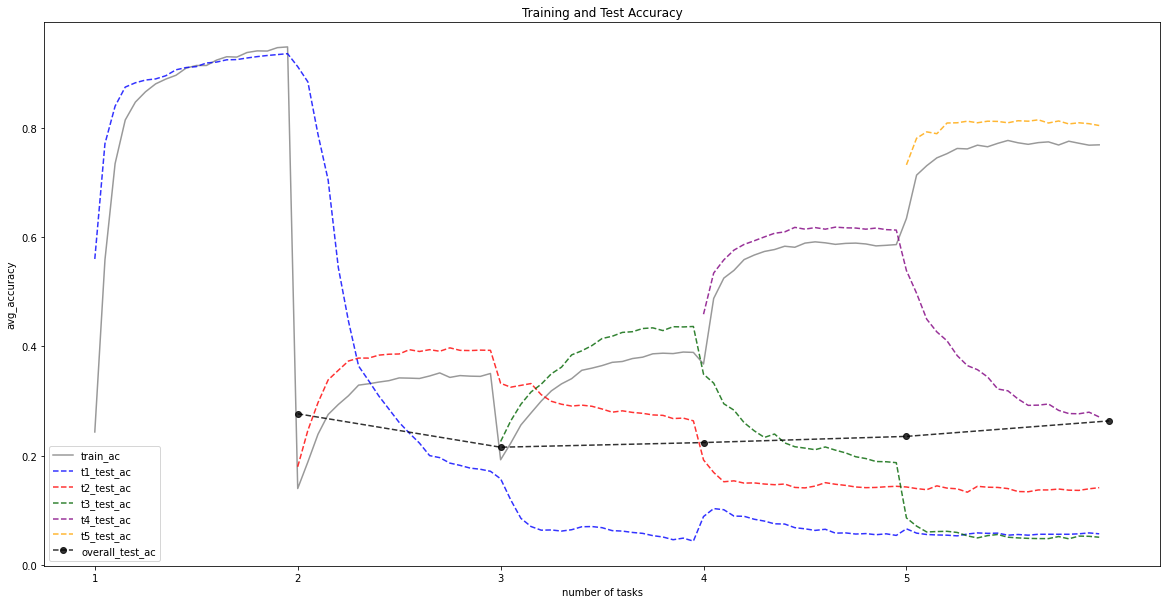

In [31]:
#Plot - use all data in test accuracy of each task
plt.figure(figsize=[20,10])
plt.plot(np.arange(0, int(5*num_epoch)), train_ac_list, color='grey', linestyle='-', label='train_ac', alpha=0.8)
plt.plot(np.arange(0, int(5*num_epoch)), t1_test_ac_list, color='blue', linestyle='--', label='t1_test_ac', alpha=0.8)
plt.plot(np.arange(int(1*num_epoch), int(5*num_epoch)), t2_test_ac_list, color='red', linestyle='--', label='t2_test_ac', alpha=0.8)
plt.plot(np.arange(int(2*num_epoch), int(5*num_epoch)), t3_test_ac_list, color='darkgreen', linestyle='--', label='t3_test_ac', alpha=0.8)
plt.plot(np.arange(int(3*num_epoch), int(5*num_epoch)), t4_test_ac_list, color='purple', linestyle='--', label='t4_test_ac', alpha=0.8)
plt.plot(np.arange(int(4*num_epoch), int(5*num_epoch)), t5_test_ac_list, color='orange', linestyle='--', label='t5_test_ac', alpha=0.8)
plt.plot([20, 40, 60, 80, 100], test_ac_list, color='black', marker='o', linestyle='--', label='overall_test_ac', alpha=0.8)
plt.legend()
plt.title("Training and Test Accuracy")
plt.xlabel("number of tasks")
plt.ylabel("avg_accuracy")
plt.xticks([0, 20, 40, 60, 80],[1, 2, 3, 4, 5])
plt.show()

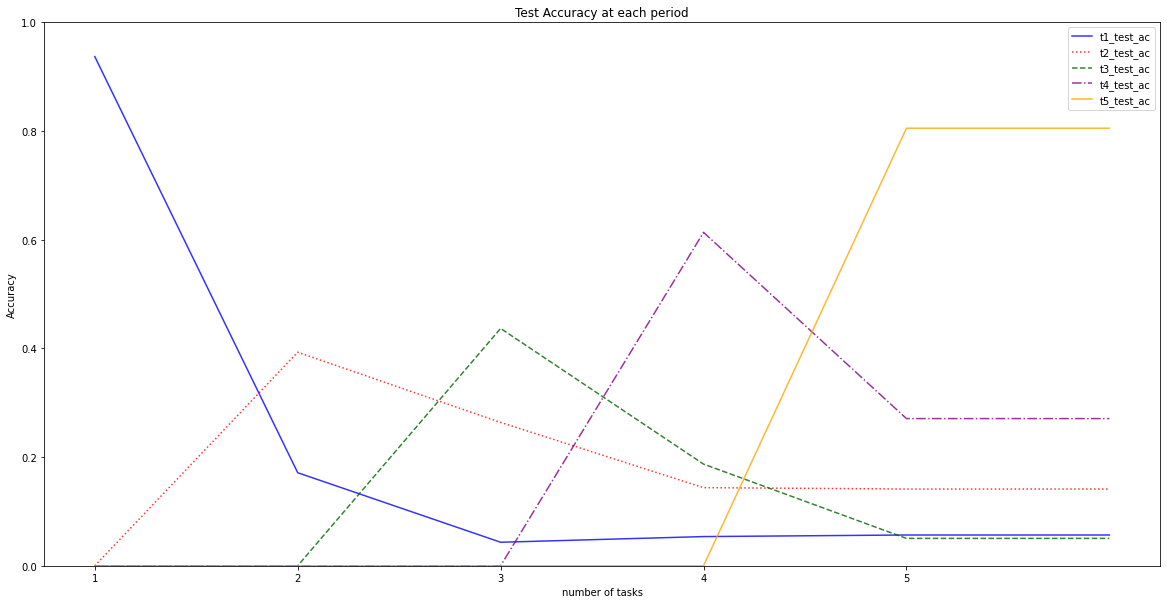

In [34]:
#Plot - average accuracy of each task
for i in range(5):
  task_ac_list[i][5] = task_ac_list[i][4]

plt.figure(figsize=[20,10])
plt.plot(np.arange(1, 7), task_ac_list[0], color='blue', linestyle='solid', label='t1_test_ac', alpha=0.8)
plt.plot(np.arange(1, 7), task_ac_list[1], color='red', linestyle='dotted', label='t2_test_ac', alpha=0.8)
plt.plot(np.arange(1, 7), task_ac_list[2], color='darkgreen', linestyle='dashed', label='t3_test_ac', alpha=0.8)
plt.plot(np.arange(1, 7), task_ac_list[3], color='purple', linestyle='dashdot', label='t4_test_ac', alpha=0.8)
plt.plot(np.arange(1, 7), task_ac_list[4], color='orange', linestyle='solid', label='t5_test_ac', alpha=0.8)
plt.legend()
plt.title("Test Accuracy at each period")
plt.xlabel("number of tasks")
plt.ylabel("Accuracy")
plt.xticks([1, 2, 3, 4, 5])
plt.ylim([0, 1])
plt.show()



Predict 



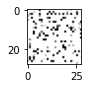

true_label: 8, y_pred: 6



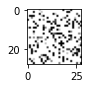

true_label: 5, y_pred: 1



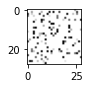

true_label: 4, y_pred: 7



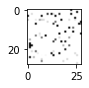

true_label: 1, y_pred: 7



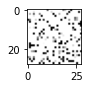

true_label: 3, y_pred: 9



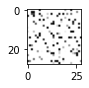

true_label: 7, y_pred: 6



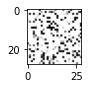

true_label: 7, y_pred: 1



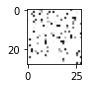

true_label: 7, y_pred: 6



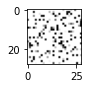

true_label: 5, y_pred: 4



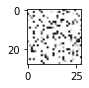

true_label: 0, y_pred: 1



In [33]:
#Predict Sample 10 examples from MNIST
print("\nPredict \n")
idx = np.random.choice(10000, 10, True)

for i in idx:
    image = test_loader.dataset[i][0].reshape(1, 1, 28*28).float()
    output = model(image.to(device))
    y_pred = torch.argmax(output, dim=1)
    
    plt.figure(figsize=(1, 1))
    plt.imshow(test_loader.dataset[i][0].reshape(28,28), cmap=plt.cm.gray_r)
    plt.show()
    print("true_label: {}, y_pred: {}\n".format(test_loader.dataset[i][1], y_pred[0]))
